In [2]:
import numpy as np 
import pandas as pd

#For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


#For text preprocessing
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as Layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
train = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv',encoding='latin1')
test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv',encoding='latin1')

In [4]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

# Data Visualization of different sentiments classes




In [7]:
#Defining variables to count the appearances of each sentiments in the dataset
print("Train")
dist_train = train['Sentiment'].value_counts()
print(dist_train)
print("Test")
dist_test = test['Sentiment'].value_counts()
print(dist_test)

Train
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64
Test
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64


Text(0, 0.5, 'Count')

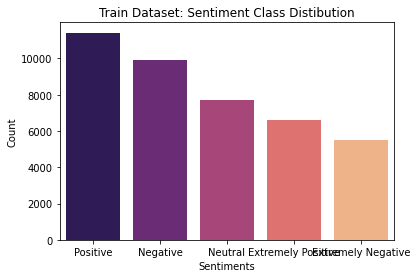

In [8]:
#Create plot
sns.barplot(x= dist_train.index, y= dist_train.values, palette = 'magma')

#Set the size of plot
sns.set(rc = {'figure.figsize':(20,7)})

#Set the title for plot
plt.title('Train Dataset: Sentiment Class Distibution')

#Label the X axis of the plot
plt.xlabel('Sentiments')

#Label the Y axis of the plot
plt.ylabel('Count')

In [9]:
t=train['Location'].value_counts()[:10]
import plotly.express as px

fig = px.bar(t,y='Location', color=t.index)
fig.show()

In [10]:

train['OriginalTweet']

0        @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia: Woolworths to give elde...
3        My food stock is not the only one which is emp...
4        Me, ready to go at supermarket during the #COV...
                               ...                        
41152    Airline pilots offering to stock supermarket s...
41153    Response to complaint not provided citing COVI...
41154    You know itÂs getting tough when @KameronWild...
41155    Is it wrong that the smell of hand sanitizer i...
41156    @TartiiCat Well new/used Rift S are going for ...
Name: OriginalTweet, Length: 41157, dtype: object

# Define features and target variables

In [11]:
X = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()

In [12]:
def data_cleaner(tweet):
    
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    
    return tweet

In [13]:
train['Sentiment']=train['Sentiment'].map({'Positive':0,'Negative':1,'Neutral':2,'Extremely Positive':3,
                                           'Extremely Negative':4})

In [14]:
#Defining a variable for stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
#Apply the above defined function to train dataset
X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

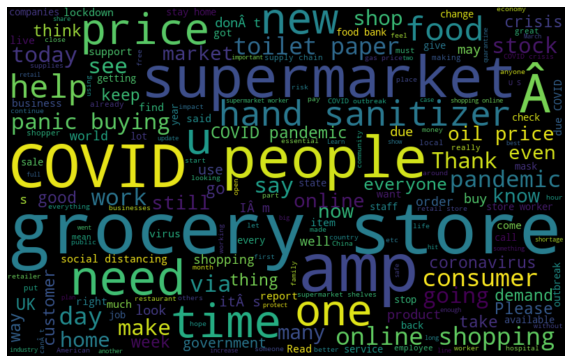

In [16]:
import wordcloud
all_words = ' '.join([text for text in X_cleaned])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

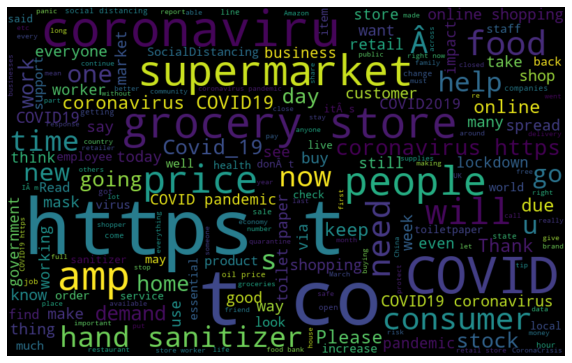

In [17]:
Positive =' '.join([text for text in train['OriginalTweet'][train['Sentiment'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(Positive)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

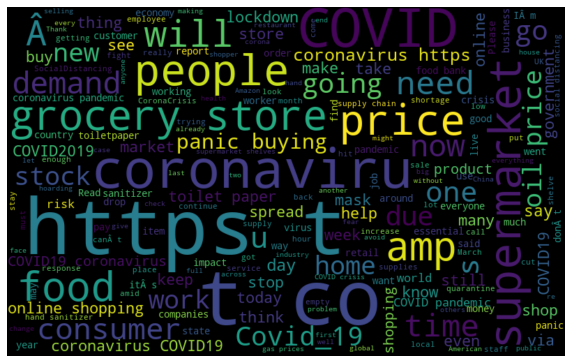

In [18]:
Negative =' '.join([text for text in train['OriginalTweet'][train['Sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(Negative)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

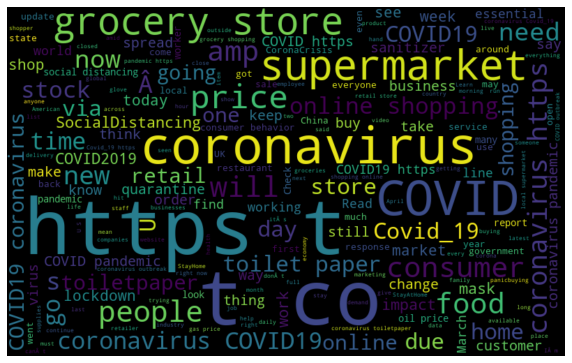

In [19]:
Neutral =' '.join([text for text in train['OriginalTweet'][train['Sentiment'] == 2]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(Neutral)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

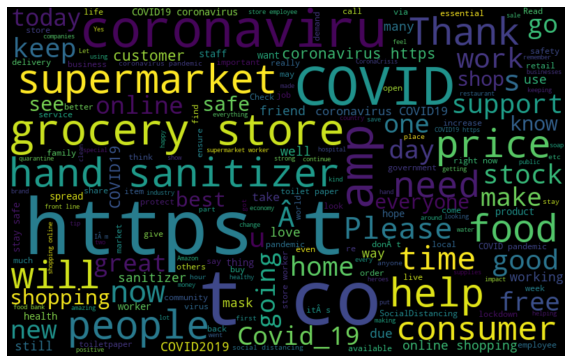

In [20]:
Extremely_Positive =' '.join([text for text in train['OriginalTweet'][train['Sentiment'] == 3]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(Extremely_Positive)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

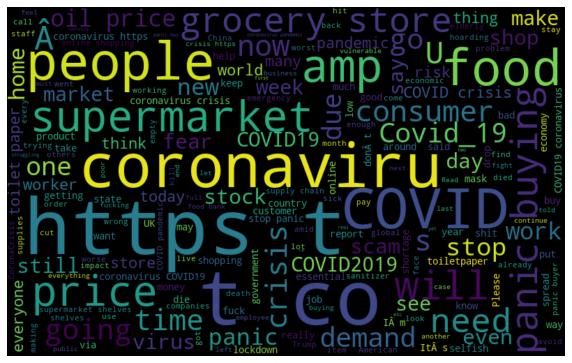

In [21]:
Extremely_Negative =' '.join([text for text in train['OriginalTweet'][train['Sentiment'] == 4]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(Extremely_Negative)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)
X = tokenizer.texts_to_sequences(X_cleaned)
vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nFor Example:\n")
print("Sentence:\n{}".format(X_cleaned[1]))
print("\nAfter tokenizing :\n{}".format(X[1]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[1]))

Vocabulary size: 36117

For Example:

Sentence:
advice Talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist GP set online shopping accounts poss adequate supplies regular meds order

After tokenizing :
[440, 820, 2520, 201, 2636, 802, 1181, 1029, 363, 320, 802, 1181, 2520, 1163, 3517, 3254, 4534, 420, 13, 12, 2257, 18314, 3046, 120, 989, 2850, 166]

After padding :
[  440   820  2520   201  2636   802  1181  1029   363   320   802  1181
  2520  1163  3517  3254  4534   420    13    12  2257 18314  3046   120
   989  2850   166     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [23]:
encoding = {'Extremely Negative': 0,'Negative': 0,'Neutral': 1,'Positive':2,'Extremely Positive': 2}

labels = ['Negative', 'Neutral', 'Positive']
           
y.replace(encoding, inplace=True)
y

0        1
1        2
2        2
3        2
4        0
        ..
41152    1
41153    0
41154    2
41155    1
41156    0
Name: Sentiment, Length: 41157, dtype: int64

In [39]:
tf.keras.backend.clear_session()

# hyper parameters
EPOCHS = 4
BATCH_SIZE = 32
embedding_dim = 16
units = 256

model = tf.keras.Sequential([
    Layers.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    Layers.Bidirectional(Layers.LSTM(units,return_sequences=True)),
    Layers.GlobalMaxPool1D(),
    Layers.Dropout(0.4),
    Layers.Dense(64, activation="relu"),
    Layers.Dropout(0.4),
    Layers.Dense(3)
])


model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 54, 16)            577872    
_________________________________________________________________
bidirectional (Bidirectional (None, 54, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [40]:
history = model.fit(X, y, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE)

Epoch 1/4
1132/1132 [==============================] - 17s 12ms/step - loss: 0.6644 - accuracy: 0.7163 - val_loss: 0.3927 - val_accuracy: 0.8672
Epoch 2/4
1132/1132 [==============================] - 14s 12ms/step - loss: 0.3317 - accuracy: 0.8943 - val_loss: 0.3719 - val_accuracy: 0.8696
Epoch 3/4
1132/1132 [==============================] - 13s 12ms/step - loss: 0.2321 - accuracy: 0.9283 - val_loss: 0.4036 - val_accuracy: 0.8722
Epoch 4/4
1132/1132 [==============================] - 13s 12ms/step - loss: 0.1764 - accuracy: 0.9453 - val_loss: 0.4779 - val_accuracy: 0.8603


In [43]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()

#Apply the tweets preprocessing functions to test dataset
X_test = X_test.apply(data_cleaner)

X_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(X_test, padding='post')

y_test.replace(encoding, inplace=True)

In [44]:
pred = model.predict(X_test)
pred

array([[ 3.4196942 , -1.5208094 , -0.95957136],
       [-3.3753545 , -3.1324556 ,  3.9149337 ],
       [-6.423892  , -6.805636  ,  7.810783  ],
       ...,
       [-2.4653766 ,  4.695079  , -3.2518103 ],
       [ 5.449732  , -2.3752847 , -1.2012302 ],
       [-6.7587347 , -7.416431  ,  8.254267  ]], dtype=float32)

In [45]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.5633638501167297
Test Accuracy: 0.8314902782440186


In [46]:
y_test_arg=np.argmax(y_test,axis=0)
Y_pred = np.argmax(model.predict(X_test),axis=1)

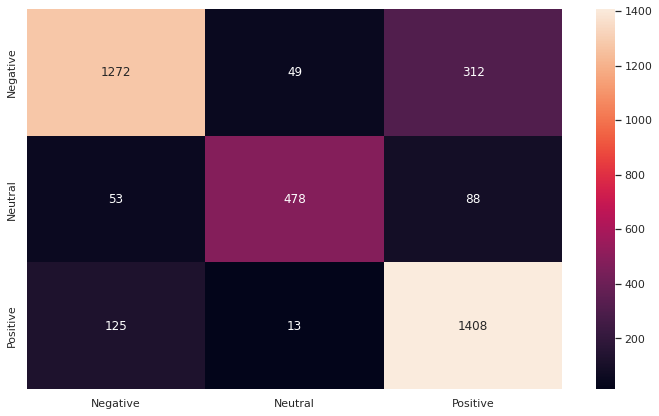

In [47]:
conf = confusion_matrix(y_test, Y_pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [48]:
print(classification_report(y_test, Y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.88      0.78      0.83      1633
     Neutral       0.89      0.77      0.82       619
    Positive       0.78      0.91      0.84      1546

    accuracy                           0.83      3798
   macro avg       0.85      0.82      0.83      3798
weighted avg       0.84      0.83      0.83      3798

